In [1]:
# example plotting script using cartopy

In [2]:
import numpy as np
from matplotlib import pyplot as plt
from netCDF4 import Dataset
import matplotlib
import matplotlib.colors as colors
import metpy.calc as mpc
import xarray as xr
from utils import *
import cartopy.crs as ccrs
import matplotlib.patches as mpatches
import cartopy.util as cutil

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

In [3]:
small_earth_fact = 20 
center_lat = 0
center_lon = np.deg2rad(90)
e1 = 10 # exponent
e2 = 10 # exponent
e3 = 10 # exponent
xlon = 40000 # m
xlat = 300000 # m
xgap = 25000 # m
d1 = xlon / (2*6371000.0/small_earth_fact)*np.power(np.log(10), -1.0/e1) # scale factors
d2 = xlat / (2*6371000.0/small_earth_fact)*np.power(np.log(10), -1.0/e2)
d3 = xgap / (2*6371000.0/small_earth_fact)*np.power(np.log(10), -1.0/e3)
h_val = 1500 # meters

In [4]:
def mountain_shape(lats, lons, z_val): # shape of the mountain
    filter = np.zeros(np.shape(lats))
    gpart = 1.0 - np.exp(-np.power((lats - center_lat)/d3, e3))
    hpart = h_val * np.exp(-np.power((lons - center_lon)/d1, e1) -np.power((lats - center_lat)/d2, e2))
    height = gpart * hpart
    count = 0
    x = np.zeros(np.size(lons))
    y = np.zeros(np.size(lons))
    for j in range(np.size(lon_inds)):
        for i in range(np.size(lat_inds)):
            if (height[i, j] > z_val):
                filter[i, j] = 1.0
                count += 1
                x[count-1] = lons[i, j]
                y[count-1] = lats[i, j]
    return np.rad2deg(x[0:count]), np.rad2deg(y[0:count])

In [5]:
# Information about the paths
model = 'MPAS' # 'SE' or 'FV3' or 'MPAS'
vert = 'hydrostatic' # or 'nonhydrostatic'

# Name of your CAM clone:
CAM_dirname = 'CAM_6_4_060_06032025'

# Edit this to your own case name
case = 'dcmip2025_horiz_mount_flow_mpasa120'

# Modify the following according to your naming convention
nc_file = case + '.cam.h0i.0001-01-01-00000_gap_with_rot.regrid.1x1.nc'

# Define the base root to the data, add your username
username = 'timand'
run_base = f'/glade/derecho/scratch/{username}/'
output_base = f'/glade/u/home/{username}/'

In [6]:
# Automatically set some paths
run_path = run_base + case + '/run/' + nc_file
output_dir = f'{CAM_dirname}/plotting/'
output_file = output_base + output_dir

In [7]:
ds = xr.open_dataset(run_path)

In [8]:
time_stamps = ds['time']
lats = ds['lat']
lons = ds['lon']
levs = ds['lev']
z_val = 300

In [9]:
# Crop to the subdomain of interest

lon_crop_left = 70.
lon_crop_right = 250.
lon_ticks = np.linspace(80, 220, 8) # Plotting ticks

lat_crop_up = 40.
lat_crop_down = -40.
lat_ticks = np.linspace(-40,40,5) # Plotting ticks


lon_inds = np.where((lons > lon_crop_left) & (lons < lon_crop_right))[0]
lat_inds = np.where((lats > lat_crop_down) & (lats < lat_crop_up))[0]

print(f'Crop is of size, {len(lat_inds)} lat vals and {len(lon_inds)} lon vals')

lat_slice = lats[lat_inds] 
lon_slice = lons[lon_inds] 
LON_subset, LAT_subset = np.meshgrid(lon_slice, lat_slice)
mountain_x, mountain_y = mountain_shape(np.deg2rad(LAT_subset), np.deg2rad(LON_subset), z_val)

Crop is of size, 80 lat vals and 180 lon vals


In [10]:
data = ds[['U', 'V']].isel(time=20).interp(lev=z_val, method='linear')
vor = mpc.vorticity(data['U'], data['V'])

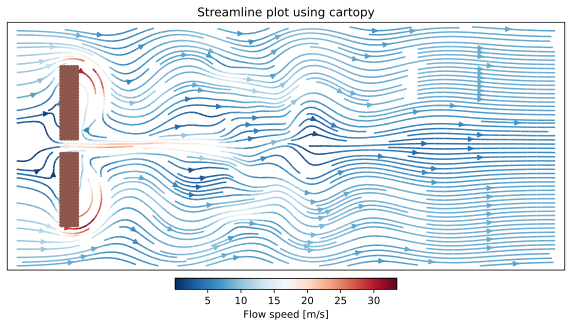

In [11]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())
ax.set_extent([70-180, 250-180, -40, 40], crs=ccrs.PlateCarree())
magnitude = np.sqrt(np.square(data['U']) + np.square(data['V']))
plot = ax.streamplot(lon_slice-180, lat_slice, data['U'].isel(lat=lat_inds, lon=lon_inds).data, data['V'].isel(lat=lat_inds, lon=lon_inds).data, transform=ccrs.PlateCarree(), density=2, cmap='RdBu_r', color=magnitude.isel(lat=lat_inds, lon=lon_inds).data, broken_streamlines=True)
ax.scatter(mountain_x-180, mountain_y, color='tab:brown', s=12, marker='o', transform=ccrs.PlateCarree(), zorder=3)
fig.colorbar(plot.lines, location='bottom', fraction=0.04, pad=0.03, label='Flow speed [m/s]')
plt.title('Streamline plot using cartopy')
ax.set_aspect('equal')
plt.show()

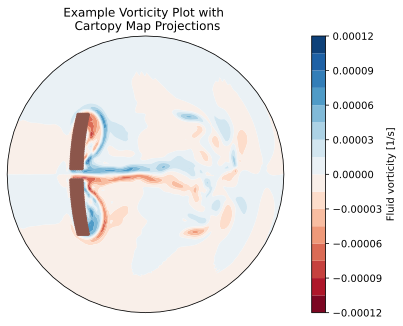

In [12]:
fig = plt.figure(figsize=(10, 5))
proj = ccrs.Orthographic(central_latitude=0, central_longitude=120)
# proj = ccrs.Mollweide()
ax = fig.add_subplot(1, 1, 1, projection=proj)
cdata, clon, clat = cutil.add_cyclic(vor, vor['lon'], vor['lat'])
ax.set_global()
contour = ax.contourf(clon, clat, cdata, transform=ccrs.PlateCarree(), levels=15, cmap='RdBu')
ax.scatter(mountain_x, mountain_y, color='tab:brown', s=10, marker='o', transform=ccrs.PlateCarree(), zorder=3)
cb = fig.colorbar(contour, ax=ax, fraction=0.025, location='right', label='Fluid vorticity [1/s]')
plt.title('Example Vorticity Plot with \n Cartopy Map Projections')
plt.show()